In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
flightVN = pd.read_csv("flight_data_cleaned.csv")

In [36]:
flightVN.head()

,price,airline,fare_class,depart_time,depart_date,arrival_time,arrival_date,src,dest,cabin_luggage,hand_luggage,urgent
0,2826000,VietnamAirlines,economy,morning,week_day,morning,week_day,CXR,HAN,23,12,yes
1,2189000,VietJetAir,economy,morning,week_day,morning,week_day,CXR,HAN,0,7,yes
2,1648000,VietnamAirlines,economy,night,week_day,night,week_day,CXR,HAN,23,12,yes
3,1854000,VietJetAir,economy,night,week_day,night,week_day,CXR,HAN,0,7,yes
4,1875000,VietnamAirlines,economy,night,week_day,night,week_day,CXR,HAN,23,12,yes


# XGBoost, AdaBoost, Random Forest, Decision Tree (Machine Learning)

## 1 Airline
## 2 Taxes
## 3 Source - Destination (planned to convert into distance in km)
## 4 Departure time ( morning, afternoon, evening, night )
## 5 Arrival time ( morning, noon, afternoon, evening, night )
## 6 Flight duration (hour)
## 7 Type of flight ticket (Economy or Business)
## 8 Days on week ( week day, weekend )

In [5]:
flight_VN = flightVN.copy()

In [6]:
flight_VN.head()

,price,airline,fare_class,depart_time,depart_date,arrival_time,arrival_date,src,dest,cabin_luggage,hand_luggage,urgent
0,2826000,VietnamAirlines,economy,morning,week_day,morning,week_day,CXR,HAN,23,12,yes
1,2189000,VietJetAir,economy,morning,week_day,morning,week_day,CXR,HAN,0,7,yes
2,1648000,VietnamAirlines,economy,night,week_day,night,week_day,CXR,HAN,23,12,yes
3,1854000,VietJetAir,economy,night,week_day,night,week_day,CXR,HAN,0,7,yes
4,1875000,VietnamAirlines,economy,night,week_day,night,week_day,CXR,HAN,23,12,yes


### Categorize airlines

In [7]:
airline = pd.get_dummies(flight_VN['airline'],dtype='int')
for airlines in airline.columns:
    flight_VN[airlines] = airline[airlines]
flight_VN = flight_VN.drop(['airline'],axis=1)

### Categorize ticket

In [8]:
flight_VN['fare_class'] = flight_VN['fare_class'].replace('economy',0)
flight_VN['fare_class'] = flight_VN['fare_class'].replace('business',1)

### Categorize departure time and arrival time

In [9]:
time = pd.get_dummies(flight_VN['depart_time'],dtype='int')
for times in time.columns:
    flight_VN[f'd_{times}'] = time[times]

In [10]:
time = pd.get_dummies(flight_VN['arrival_time'],dtype='int')
for times in time.columns:
    flight_VN[f'a_{times}'] = time[times]

In [11]:
flight_VN = flight_VN.drop(['depart_time','arrival_time'],axis=1)

### Categorize depart date and arrival date

In [12]:
flight_VN['depart_date'] = flight_VN['depart_date'].replace('week_day',0)
flight_VN['depart_date'] = flight_VN['depart_date'].replace('weekend',1)
flight_VN['arrival_date'] = flight_VN['arrival_date'].replace('weekend',1)
flight_VN['arrival_date'] = flight_VN['arrival_date'].replace('week_day',0)

### categorize source and destination

In [13]:
source = pd.get_dummies(flight_VN['src'],dtype='int')
for sources in source.columns:
    flight_VN[f'from_{sources}'] = source[sources]

In [14]:
destination = pd.get_dummies(flight_VN['dest'],dtype='int')
for destinations in destination.columns:
    flight_VN[f'to_{destinations}'] = destination[destinations]

In [15]:
flight_VN = flight_VN.drop(['src','dest'],axis=1)

### categorize urgent feature

In [16]:
flight_VN['urgent'] = flight_VN['urgent'].replace('yes',1)
flight_VN['urgent'] = flight_VN['urgent'].replace('no',0)

In [17]:
flight_VN.head()

,price,fare_class,depart_date,arrival_date,cabin_luggage,hand_luggage,urgent,BambooAirways,VietJetAir,VietnamAirlines,...,from_CXR,from_DAD,from_HAN,from_PQC,from_SGN,to_CXR,to_DAD,to_HAN,to_PQC,to_SGN
0,2826000,0,0,0,23,12,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
1,2189000,0,0,0,0,7,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,1648000,0,0,0,23,12,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,1854000,0,0,0,0,7,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,1875000,0,0,0,23,12,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0


In [18]:
flight_VN.columns

Index(['price', 'fare_class', 'depart_date', 'arrival_date', 'cabin_luggage',
       'hand_luggage', 'urgent', 'BambooAirways', 'VietJetAir',
       'VietnamAirlines', 'd_afternoon', 'd_evening', 'd_morning', 'd_night',
       'a_afternoon', 'a_evening', 'a_morning', 'a_night', 'from_CXR',
       'from_DAD', 'from_HAN', 'from_PQC', 'from_SGN', 'to_CXR', 'to_DAD',
       'to_HAN', 'to_PQC', 'to_SGN'],
      dtype='object')

In [19]:
per25 = flight_VN['price'].quantile(0.25)
per75 = flight_VN['price'].quantile(0.75)
IQR = per75 - per25
upper = per75 + 1.5*IQR
lower = per25 - 1.5*IQR
flight_VN['price'] = np.where(flight_VN['price'] > upper,upper, flight_VN['price'])
flight_VN['price'] =  np.where(flight_VN['price'] < lower, lower, flight_VN['price'])
flight_VN.head()

,price,fare_class,depart_date,arrival_date,cabin_luggage,hand_luggage,urgent,BambooAirways,VietJetAir,VietnamAirlines,...,from_CXR,from_DAD,from_HAN,from_PQC,from_SGN,to_CXR,to_DAD,to_HAN,to_PQC,to_SGN
0,2826000.0,0,0,0,23,12,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
1,2189000.0,0,0,0,0,7,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,1648000.0,0,0,0,23,12,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,1854000.0,0,0,0,0,7,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,1875000.0,0,0,0,23,12,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0


# Model

 ### R-squared (R2), Mean Absolute Error (MAE) and Mean Squared Error (MSE)

In [30]:


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV

In [24]:
X_features = []
Y_features = []

for columns in flight_VN.columns:
    if columns == 'price':
        Y_features.append(columns)
    else:
        X_features.append(columns)

X = flight_VN[X_features]
Y = flight_VN[Y_features[0]]

In [25]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.20, random_state = 42)

In [26]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.fit_transform(X_test)

## Decision Tree

In [27]:
from sklearn.tree import DecisionTreeRegressor
clf_param ={
    "criterion" : ['squared_error'],
    "max_depth":[i for i in range(2,100,10)],
    "max_features":[1.0], #auto
    "min_samples_split":[i for i in range(2,100,20)]
}
clf_en = GridSearchCV(DecisionTreeRegressor(),clf_param)
clf_en.fit(X_train, Y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error'],
                         'max_depth': [2, 12, 22, 32, 42, 52, 62, 72, 82, 92],
                         'max_features': [1.0],
                         'min_samples_split': [2, 22, 42, 62, 82]})

In [28]:
clf_en.best_estimator_ 

DecisionTreeRegressor(max_depth=12, max_features=1.0, min_samples_split=62)

In [32]:
clf_en_prediction = clf_en.best_estimator_.predict(X_test)
print("Mean Absolute Error: " + str(mean_absolute_error(clf_en_prediction, Y_test)))
print("R-square: " + str(r2_score(clf_en_prediction, Y_test)))
print("Root mean squared Error: " + str(root_mean_squared_error(clf_en_prediction, Y_test)))

Mean Absolute Error: 432882.35525654297
R-square: 0.7339792642140984
Root mean squared Error: 639928.9494140384


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
n_estimators = [i for i in range(10,100,10)]
min_sample_split = [i for i in range(2,100,20)]
rfc_param ={
    "n_estimators": n_estimators,
    "criterion" : ['squared_error'],
    "max_features":[1.0], #auto,  
}

rfc = GridSearchCV(RandomForestRegressor(), rfc_param)
rfc.fit(X_train, Y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error'], 'max_features': [1.0],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90]})

In [ ]:
rfc.best_estimator_

RandomForestRegressor(n_estimators=60)

In [ ]:
rf_prediction = rfc.best_estimator_.predict(X_test)
print("Mean Absolute Error: " + str(mean_absolute_error(rf_prediction, Y_test)))
print("R-square: " + str(r2_score(rf_prediction, Y_test)))
print("Mean squared Error: " + str(root_mean_squared_error(rf_prediction, Y_test)))

Mean Absolute Error: 430474.4118906996
R-square: 0.7372431352596833
Mean squared Error: 404880585342.2036


## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
adaboost_param = {
    "n_estimators":[i for i in range(10,100,10)],
    'loss':['linear','square', 'exponential']
}

adaboost = GridSearchCV(AdaBoostRegressor(), adaboost_param)
adaboost.fit(X_train,Y_train)

NameError: name 'X_train' is not defined

In [ ]:
adaboost.best_estimator_

AdaBoostRegressor(n_estimators=60)

In [ ]:
adaboost_prediction = adaboost.predict(X_test)
print("Mean Absolute Error: " + str(mean_absolute_error(adaboost_prediction, Y_test)))
print("R-square: " + str(r2_score(adaboost_prediction, Y_test)))
print("Mean squared Error: " + str(root_mean_squared_error(adaboost_prediction, Y_test)))

Mean Absolute Error: 709609.418509077
R-square: 0.24201506122898475
Mean squared Error: 770805615262.3269


## XGBoost

In [ ]:
from xgboost import XGBRegressor


xgboost_param = {
    "max_depth":[1,2,3,4,5,6,7,8,9,10],
    "subsample":[1.0], #use all sample
    "colsample_bytree":[1.0] #use all features
}

xgboost = GridSearchCV(XGBRegressor(),xgboost_param)
xgboost.fit(X_train, Y_train)


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [1.0],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'subsample': [1.0]})

In [36]:
xgboost.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [37]:
xgboost_prediction = xgboost.predict(X_test)
print("Mean Absolute Error: " + str(mean_absolute_error(xgboost_prediction, Y_test)))
print("R-square: " + str(r2_score(xgboost_prediction, Y_test)))
print("Mean squared Error: " + str(root_mean_squared_error(xgboost_prediction, Y_test)))

Mean Absolute Error: 511089.15943490947
R-square: 0.6476012274343814
Mean squared Error: 520494111697.3286


In [38]:
import joblib
joblib.dump(xgboost.best_estimator_, 'xgboost.pkl')
joblib.dump(adaboost.best_estimator_, 'adaboost.pkl')
joblib.dump(rfc.best_estimator_, 'random_forest.pkl')
joblib.dump(clf_en.best_estimator_, 'decision_tree.pkl')

['decision_tree.pkl']

In [39]:
import joblib
adaboost=joblib.load('adaboost.pkl')
decision_tree=joblib.load('decision_tree.pkl')
random_forest=joblib.load('random_forest.pkl')
xgboost=joblib.load('xgboost.pkl')

# Visualization

In [ ]:
xgboost_prediction = xgboost.predict(X_test)
adaboost_prediction = adaboost.predict(X_test)
rf_prediction = random_forest.predict(X_test)
clf_en_prediction = decision_tree.predict(X_test)

In [97]:
model_result = pd.DataFrame(index=['Mean Absolute Error',"R-square","Mean squared Error"])
model_list = ['XGBoost','AdaBoost','Random Forest','Decision Tree']
prediction_list = [xgboost_prediction, adaboost_prediction, rf_prediction, clf_en_prediction]
for i in range(0,len(model_list)):
    model_result[model_list[i]] = [str(mean_absolute_error(prediction_list[i], Y_test)), str(r2_score(prediction_list[i], Y_test)), str(mean_squared_error(prediction_list[i], Y_test))]

In [98]:
model_result

,XGBoost,AdaBoost,Random Forest,Decision Tree
Mean Absolute Error,511089.15943490947,709609.418509077,430474.4118906996,430638.76793455624
R-square,0.6476012274343814,0.24201506122898475,0.7372431352596833,0.7375391575137242
Mean squared Error,520494111697.3286,770805615262.3269,404880585342.2036,404241022088.2922


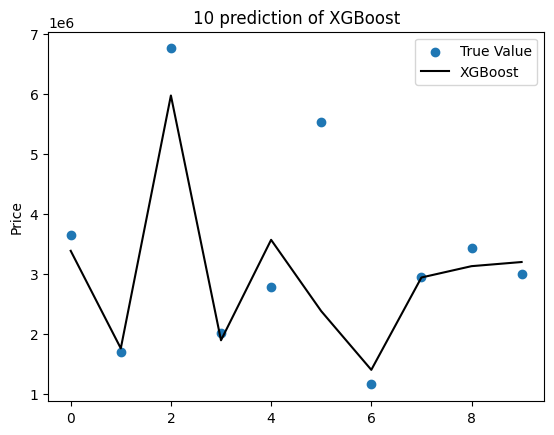

In [99]:
x = [i for i in range(0,10)]
y = Y_test[:10]

X_xgboost = [i for i in range(0,10)]
Y_xgboost = xgboost_prediction[:10]

plt.scatter(x, y)
plt.plot(X_xgboost, Y_xgboost,color='black')
plt.title('10 prediction of XGBoost')
plt.ylabel('Price')
plt.legend(['True Value','XGBoost'])
plt.show()

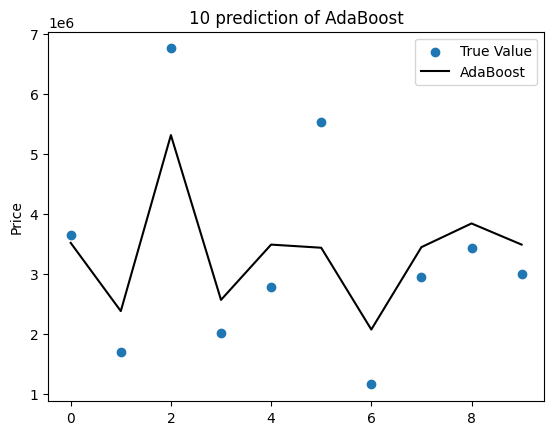

In [102]:
x = [i for i in range(0,10)]
y = Y_test[:10]

X_adaboost= [i for i in range(0,10)]
Y_adaboost = adaboost_prediction[:10]

plt.scatter(x, y)
plt.plot(X_adaboost, Y_adaboost,color='black')
plt.title('10 prediction of AdaBoost')
plt.ylabel('Price')
plt.legend(['True Value','AdaBoost'])
plt.show()

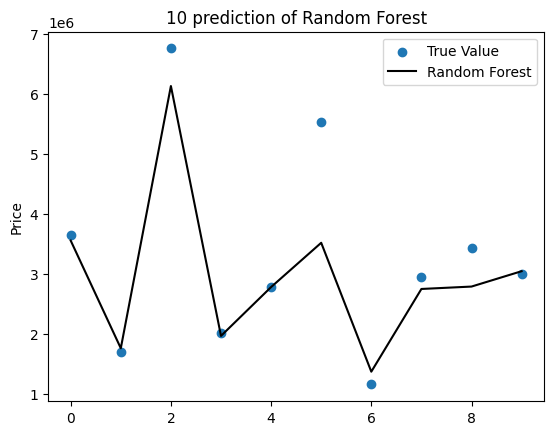

In [103]:
x = [i for i in range(0,10)]
y = Y_test[:10]

X_random_forest = [i for i in range(0,10)]
Y_random_forest = rf_prediction[:10]

plt.scatter(x, y)
plt.plot(X_random_forest, Y_random_forest ,color='black')
plt.title('10 prediction of Random Forest')
plt.ylabel('Price')
plt.legend(['True Value','Random Forest'])
plt.show()

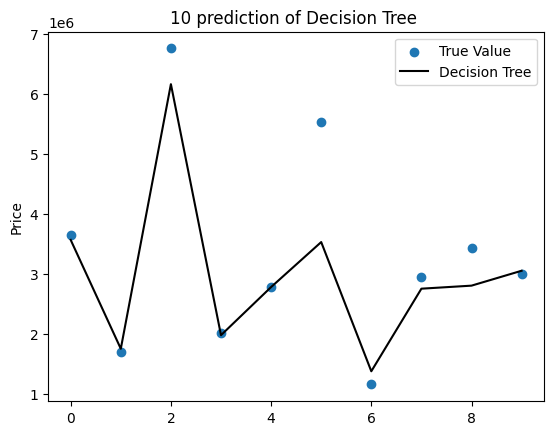

In [104]:
x = [i for i in range(0,10)]
y = Y_test[:10]

X_decision_tree = [i for i in range(0,10)]
Y_decision_tree = clf_en_prediction[:10]

plt.scatter(x, y)
plt.plot(X_decision_tree, Y_decision_tree ,color='black')
plt.title('10 prediction of Decision Tree ')
plt.ylabel('Price')
plt.legend(['True Value','Decision Tree'])
plt.show()